## Apply CNN for dog identification
To detect dogs, we create CNN to classfy dog breeds from scatch, then use CNN to classfify Dog Breeds using transfer leaning.

In [74]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# Define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load datasets (train, test, and validation)
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [75]:
# Import human dataset
import random
random.seed(8675309)
# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


### Detect humans

Number of faces detected: 1


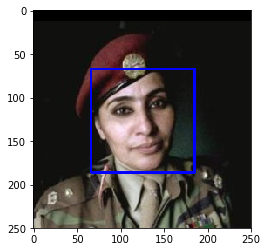

In [76]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(gray)
print('Number of faces detected:', len(faces))

# Get bounding box
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [77]:
# Funtion of human face detector
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [78]:
# Percentage of first 100 images.
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_faces = [face_detector(human_file) for human_file in human_files_short]
dog_faces = [face_detector(dog_file) for dog_file in dog_files_short]
percent_human = (np.sum(human_faces) / len(human_faces)) * 100
percent_dog = (np.sum(dog_faces) / len(dog_faces)) * 100

### Detect dogs

In [ ]:
from keras.applications.resnet50 import ResNet50
# Define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [81]:
# Function for pre-processing the data
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [82]:
# Function for prediction with ResNet-50
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [83]:
# Function for dog detector
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [84]:
# Test the performance
human_faces = [face_detector(human_file) for human_file in human_files_short]
percent_human = 100 * (np.sum(human_faces)/len(human_faces))

dog_faces = [face_detector(dog_file) for dog_file in dog_files_short]
percent_dog = 100 * (np.sum(dog_faces)/len(dog_faces))

### (1). Create a CNN to Classify Dog Breeds (from Scratch)

In [85]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 85.37it/s] 


In [89]:
# Model Architecture
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
__________

In [90]:
# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
# Train the model
from keras.callbacks import ModelCheckpoint  
epochs = 10
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.6213 - acc: 0.0355 - val_loss: 4.6766 - val_acc: 0.0275
Epoch 2/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.6036 - acc: 0.0404 - val_loss: 4.6577 - val_acc: 0.0323
Epoch 3/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.5855 - acc: 0.0410 - val_loss: 4.6502 - val_acc: 0.0335
Epoch 4/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.5645 - acc: 0.0406 - val_loss: 4.6268 - val_acc: 0.0347
Epoch 5/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.5448 - acc: 0.0464 - val_loss: 4.6215 - val_acc: 0.0407
Epoch 6/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.5246 - acc: 0.0460 - val_loss: 4.6015 - val_acc: 0.0443
Epoch 7/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.5042 - acc: 0.0496 - val_loss: 4.6036 - val_acc: 0.0479
Epoch 8/

In [93]:
# Load the model with the best validation loss
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [94]:
# Test the model
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.6651%


### (2). Use a CNN to Classify Dog Breeds (VGG16)
To reduce training time without sarcrificing accuracy, we will train a CNN using transfer learning.
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

In [ ]:
# IMPLEMENTATION to Obtain Bottleneck Features
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [96]:
# Model architecture
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Compile the model
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [98]:
# Train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 384us/step - loss: 12.5117 - acc: 0.1175 - val_loss: 11.2394 - val_acc: 0.1940
Epoch 2/20
6680/6680 [==============================] - 2s 292us/step - loss: 10.5646 - acc: 0.2597 - val_loss: 10.5214 - val_acc: 0.2515
Epoch 3/20
6680/6680 [==============================] - 2s 294us/step - loss: 9.9754 - acc: 0.3153 - val_loss: 10.0657 - val_acc: 0.2826
Epoch 4/20
6680/6680 [==============================] - 2s 291us/step - loss: 9.2729 - acc: 0.3623 - val_loss: 9.4697 - val_acc: 0.3269
Epoch 5/20
6680/6680 [==============================] - 2s 290us/step - loss: 8.9741 - acc: 0.3973 - val_loss: 9.4844 - val_acc: 0.3353
Epoch 6/20
6680/6680 [==============================] - 2s 279us/step - loss: 8.7938 - acc: 0.4190 - val_loss: 9.3144 - val_acc: 0.3413
Epoch 7/20
6680/6680 [==============================] - 2s 263us/step - loss: 8.6325 - acc: 0.4359 - val_loss: 9.0860 - val_acc: 0.3

In [99]:
# Load the model with best validation loss
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [100]:
# Test the model
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.5407%


In [101]:
# Function for Predicting dog breed
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### (3). Create CNN to classify dog breeds using transfer learning to create CNN (Xception).

In [116]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [117]:
### TODO: Define your architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape= (train_Xception.shape[1:])))
Xception_model.add(Dense(133, activation='softmax'))

In [119]:
### Compile the model.
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [121]:
### Train the model.
epochs = 10
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)
Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3s 499us/step - loss: 1.0532 - acc: 0.7425 - val_loss: 0.5477 - val_acc: 0.8192
Epoch 2/10
6680/6680 [==============================] - 3s 386us/step - loss: 0.4001 - acc: 0.8716 - val_loss: 0.5039 - val_acc: 0.8383
Epoch 3/10
6680/6680 [==============================] - 3s 385us/step - loss: 0.3184 - acc: 0.8999 - val_loss: 0.4995 - val_acc: 0.8395
Epoch 4/10
6680/6680 [==============================] - 3s 388us/step - loss: 0.2697 - acc: 0.9159 - val_loss: 0.5003 - val_acc: 0.8467
Epoch 5/10
6680/6680 [==============================] - 3s 384us/step - loss: 0.2402 - acc: 0.9256 - val_loss: 0.5242 - val_acc: 0.8551
Epoch 6/10
6680/6680 [==============================] - 3s 381us/step - loss: 0.2141 - acc: 0.9323 - val_loss: 0.5324 - val_acc: 0.8491
Epoch 7/10
6680/6680 [==============================] - 3s 384us/step - loss: 0.1924 - acc: 0.9398 - val_loss: 0.5446 - val_acc: 0.8515
E

In [122]:
### Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

In [123]:
### Calculate classification accuracy on the test dataset.
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_Xception]

test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.0909%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [124]:
# Write function to predict dog breed by the model.
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [159]:
# Write your algorithm.
def human_dog_app(file_path):
    if dog_detector(file_path):        
        print('Hi, You are Dog!')
        predicted_breed = Xception_predict_breed(file_path)
        print(predicted_breed)
    elif face_detector(file_path):        
        print('Hi, You are Human!')
        predicted_breed = Xception_predict_breed(file_path)
        print(predicted_breed)
    else:
        print('Hi, You are not Dog or Human')
        predicted_breed = Xception_predict_breed(file_path)
        print(predicted_breed)    

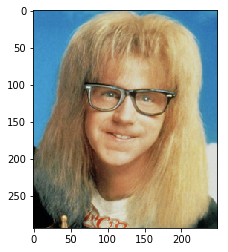

In [160]:
## Execute your algorithm from Step 6 on
img_path = 'images/sample_human_2.png'
new_img = cv2.imread(img_path)
color_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
plt.imshow(color_img)

In [161]:
# Final test
human_dog_app(img_path)

Hi, You are Human!
ages/train/002.Afghan_hound
